# Baseline Apprach
For our baseline, a straightforward attempt at interpolation is simply the average of the two frames that are being interpolated.

### Loading dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [4]:
# Use GPU if available, otherwise stick with cpu
USE_GPU = True
torch.manual_seed(123)
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [5]:
def visualize_frames_baseline(x1, x2, y, y_hat):
    H, L, W = x1.shape
    order = [x1, x2, y, y_hat]
    x = [i[H//4 * 2, :, :] for i in order]
    y = [z_stretch(i[:, L//4 * 2, :]) for i in order]
    z = [z_stretch(i[:, :, W//4 * 2]) for i in order]
    slices = x + y + z
    display_grid(3,4,slices)

In [6]:
set_figsize(20, 15)

In [7]:
validation = TAVR_3_Frame("__valid")

In [8]:
def pred(x1, x2):
    return (x1 + x2)/ 2

### Loss
For our loss function, we simply take the L2 loss between the predicted frame and the actual frame.

In [9]:
def loss(y_hat, y): #, D, max_z):
    L2 = (y_hat - y) ** 2
#     norm = L2 * D
#     scale = norm/max_z
    ret = torch.sqrt(torch.sum(L2))/torch.prod(torch.tensor(y.shape)).type(torch.float)
    return ret.numpy()

In [12]:
for bunch in validation:
    x1, y, x2 = bunch
    single_loss = loss(pred(x1, x2), y)#, D, max_z)
    print(single_loss)

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


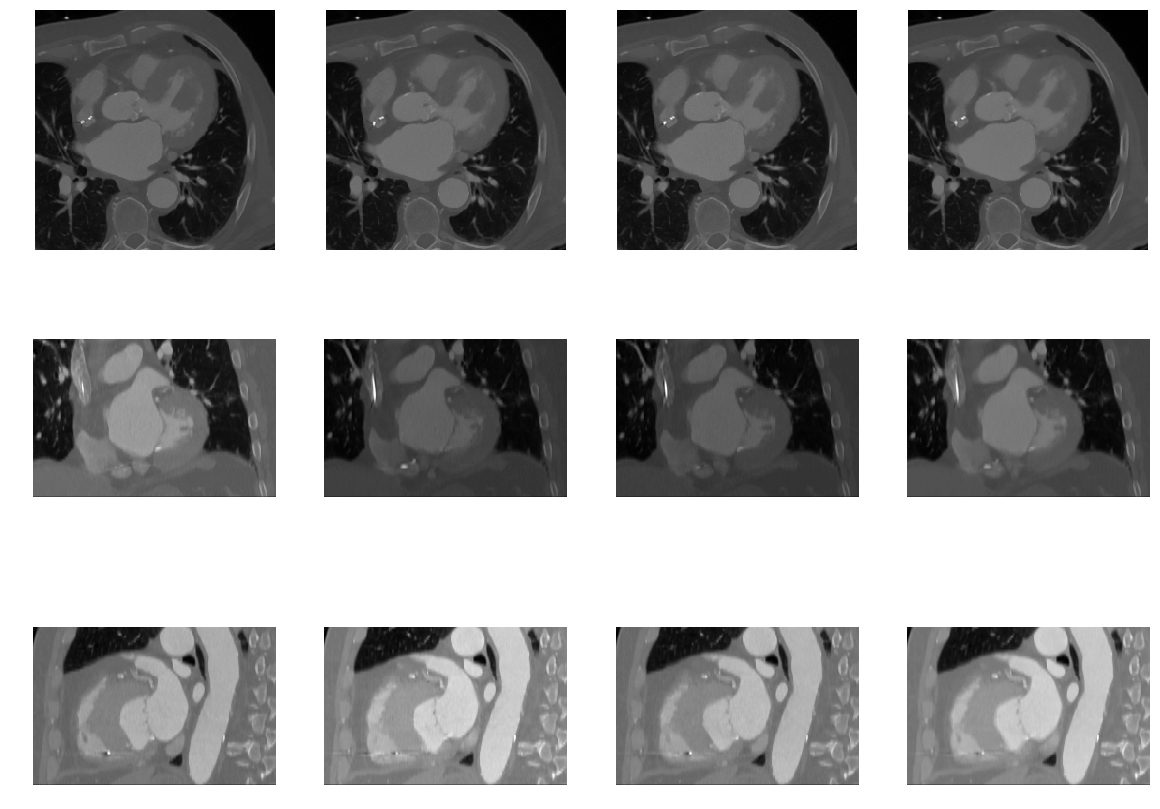

In [8]:
x1, y, x2 = validation[len(validation)//2]

visualize_frames_baseline(x1, x2, y, pred(x1, x2))

In [14]:
class average_model(nn.Module):
    def forward(self, X):
        x1, x2 = X
        return (x1 + x2)/ 2

class batch_loss(nn.Module):
    def forward(self, results):
        y, y_hat, D, max_z = results
        L2 = (y_hat-y)**2 * D
        print(L2.type())
        L2_total = torch.sqrt(torch.sum(L2))
        L2_ave = L2_total/(torch.sum(max_z) * 256 * 256)
        return L2_ave, np.sqrt(torch.max(L2).detach().numpy()), L2_total.detach().numpy()
        

In [16]:
val_loader = tavr_dataloader(validation, batch_size=8, shuffle=True, num_workers=4)
model = average_model()
L2_loss = batch_loss()

In [18]:
for batch in val_loader:
    x1, y, x2, D, max_z = batch
    y_hat = model((x1, x2))
    loss, maxloss, total = L2_loss((y, y_hat, D, max_z))
    print(loss.numpy(), maxloss, total)

torch.FloatTensor
0.0064653577 3711.5 238127.1
torch.FloatTensor
0.006251537 3574.0 237626.42
torch.FloatTensor
0.0057402393 2362.5 220824.89
torch.FloatTensor
0.0067705344 3993.5 253804.27
torch.FloatTensor
0.0062547172 1356.5 218071.67
torch.FloatTensor
0.0064883297 4003.5 224090.5
torch.FloatTensor
0.0061647044 2778.0 215741.38
torch.FloatTensor
0.0071158893 1415.0 227577.3
torch.FloatTensor
0.006767651 1618.0 209343.7
torch.FloatTensor
0.0066409046 1748.0 226313.53
torch.FloatTensor
0.013956021 1047.5 74998.984


In [19]:
class two_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_a1 = nn.Conv3d(1, 8, 3, padding=1)
        self.conv_b1 = nn.Conv3d(1, 8, 3, padding=1)
        self.final = nn.Conv3d(16, 1, 1)
        nn.init.kaiming_normal_(self.conv_a1.weight)
        nn.init.kaiming_normal_(self.conv_b1.weight)
        nn.init.kaiming_normal_(self.final.weight)
    
    def forward(self, x):
        x1, x2 = x
        a0 = x1[:,None,:,:,:]
        b0 = x2[:,None,:,:,:]
        a1 = F.relu(self.conv_a1(a0))
        b1 = F.relu(self.conv_a1(b0))
        ab = torch.cat((a1, b1), 1)
        y_hat = self.final(ab)
        return y_hat

In [20]:
model_conv = two_layer()

In [21]:
x1, y, x2, D, max_z = batch
y_hat = model_conv((x1, x2))

In [22]:
loss, maxloss, total = L2_loss((y, y_hat, D, max_z))
print(loss, maxloss, total)

torch.FloatTensor
tensor(0.7011) 10871.55 3767740.0


In [23]:
loss, maxloss, total = L2_loss((y, y_hat, D, max_z))
print(loss, maxloss, total)

torch.FloatTensor
tensor(0.7011) 10871.55 3767740.0


In [24]:
loss.backward()

In [25]:
torch.min(model_conv.conv_a1.weight.grad)

tensor(-0.2660)

In [26]:
learning_rate = 1e-3
momentum = 0.95
reg = 1e-1

optimizer = optim.SGD(model_conv.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [27]:
optimizer.step()
optimizer.zero_grad()

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


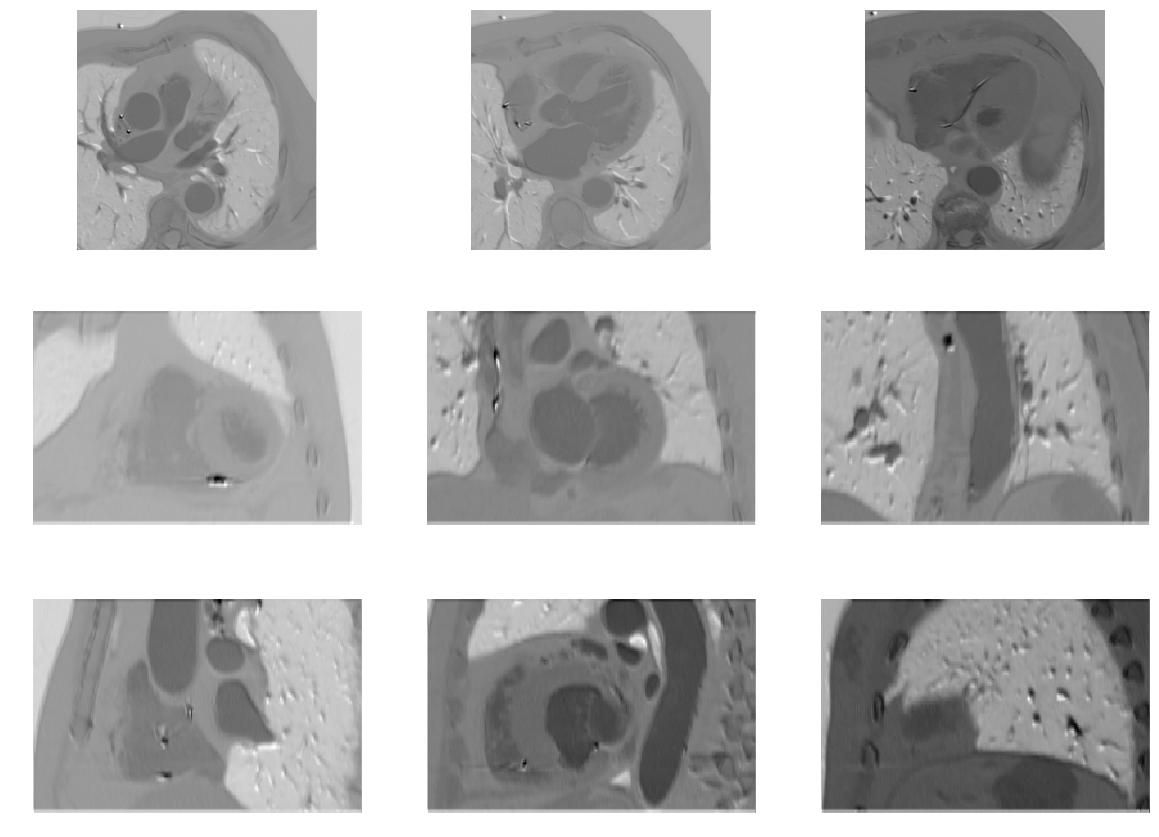

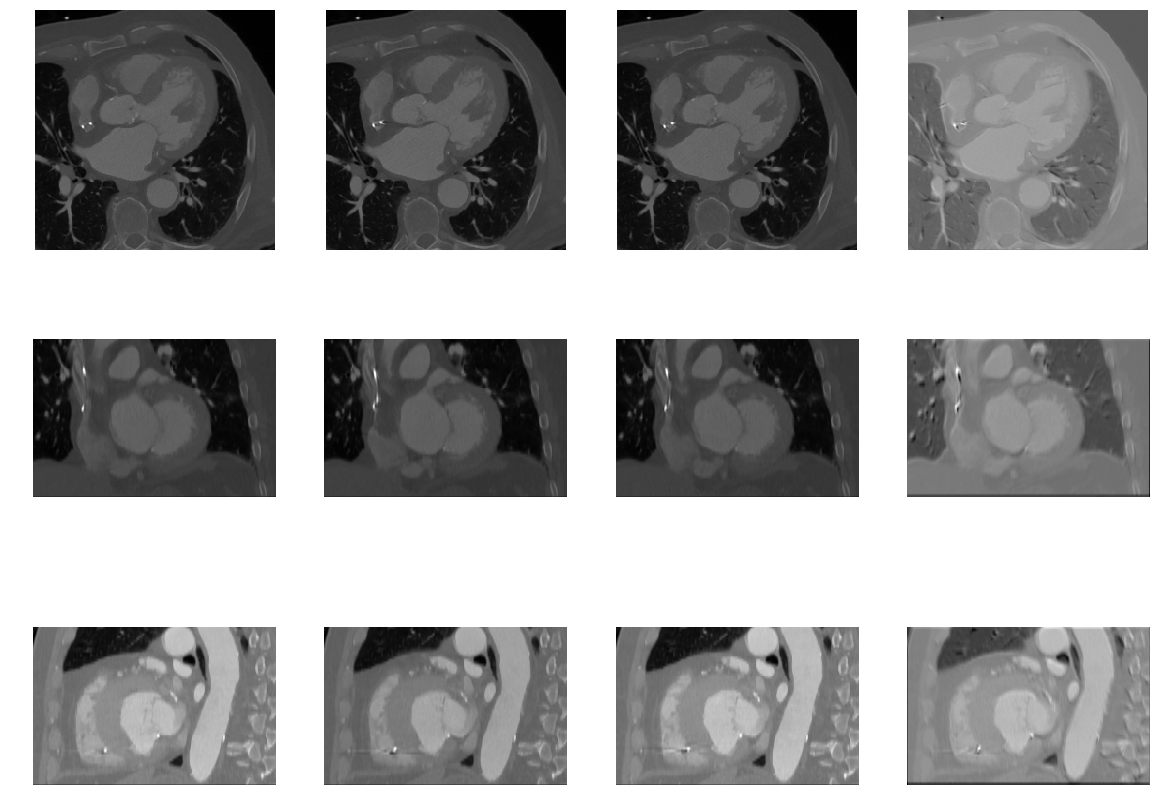

In [104]:
visualize_frame(y_hat[0][0].detach())

visualize_frames_baseline(x1[0], x2[0], y[0], -y_hat[0][0].detach())

In [78]:
y[0][30]

tensor([[   31.,    18.,    33.,  ...,    15.,    25.,    30.],
        [   57.,    38.,    43.,  ...,    22.,    15.,    24.],
        [   20.,    49.,    20.,  ...,    28.,    21.,    48.],
        ...,
        [  656.,   566.,   517.,  ...,   457.,   498.,   548.],
        [  883.,   647.,   534.,  ...,   474.,   378.,   285.],
        [  966.,   884.,   739.,  ...,   219.,   170.,   108.]])

In [103]:
torch.mean(y_hat[0][0].detach())

tensor(-1098.4197)